In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import warnings

In [2]:
NAME = 'Qzm'
LONGNAME = 'zonal mean specific humidity'
MONTHS_NH = [6,7,8,9,10]  # NH TC season months [1: Jan - 12: Dec]
MONTHS_SH = [1,2,3,4,5]   # SH TC season months

In [3]:
ds = xr.open_dataset(f'../jobs/{NAME}/data/{NAME}.nc')

ds[NAME] = (ds[NAME]*1000).assign_attrs({'units':'g/kg'})

# add anomalies to datasets
for exp in ['cnt-ref','sai-ref','sai-cnt']:
    exp1,exp2 = exp.split('-')
    diff = (ds.sel(exp=exp1) - ds.sel(exp=exp2))/ds.sel(exp=exp2)*100
    diff = diff.assign_coords(exp=exp)
    ds = xr.concat((ds,diff), dim='exp')

# add month weights and gaussian latitude weights
ds['dpm'] = ('month', [31,28,31,30,31,30,31,31,30,31,30,31])
with xr.open_dataset('../data/gw.nc').gw as gw:
    ds['gw'] = gw

# print annual mean quantile information for plotting limits
data = ds[NAME].weighted(ds.dpm).mean('month')
print(ds[NAME].attrs)
print('exp','[min, 0.02 pct, 0.98 pct, max]')
for exp in data.exp.data:
    print(exp, data.sel(exp=exp).quantile([0,0.02,0.98,1]).data)

{'units': 'g/kg'}
exp [min, 0.02 pct, 0.98 pct, max]
ref [1.06088661e-03 1.48854322e-03 1.44896972e+01 1.69825751e+01]
cnt [1.07846523e-03 1.57975354e-03 1.66584388e+01 1.96963559e+01]
sai [1.09123074e-03 1.64464826e-03 1.45103209e+01 1.71157514e+01]
cnt-ref [-37.26996971  -6.02496661  72.87617233 138.6349582 ]
sai-ref [-33.48253719  -5.77561084  58.17084679  69.93010348]
sai-cnt [-51.00182659 -38.42495037  18.18903996  24.90378117]


In [4]:
cfkwargs_abs = dict(levels=10**np.arange(-10/3,1.51,1/3), vmin=10**(-4), vmax=10**2, norm=mcolors.LogNorm(), locator=mticker.LogLocator(subs=(1,)), extend='neither', cmap='YlGnBu')
cfkwargs_rel = dict(levels=np.arange(-50,81,5), vmin=-90, vmax=90, extend='both', cmap='RdBu')
cbarunit_abs = 'g/kg'
cbarunit_rel = '%'

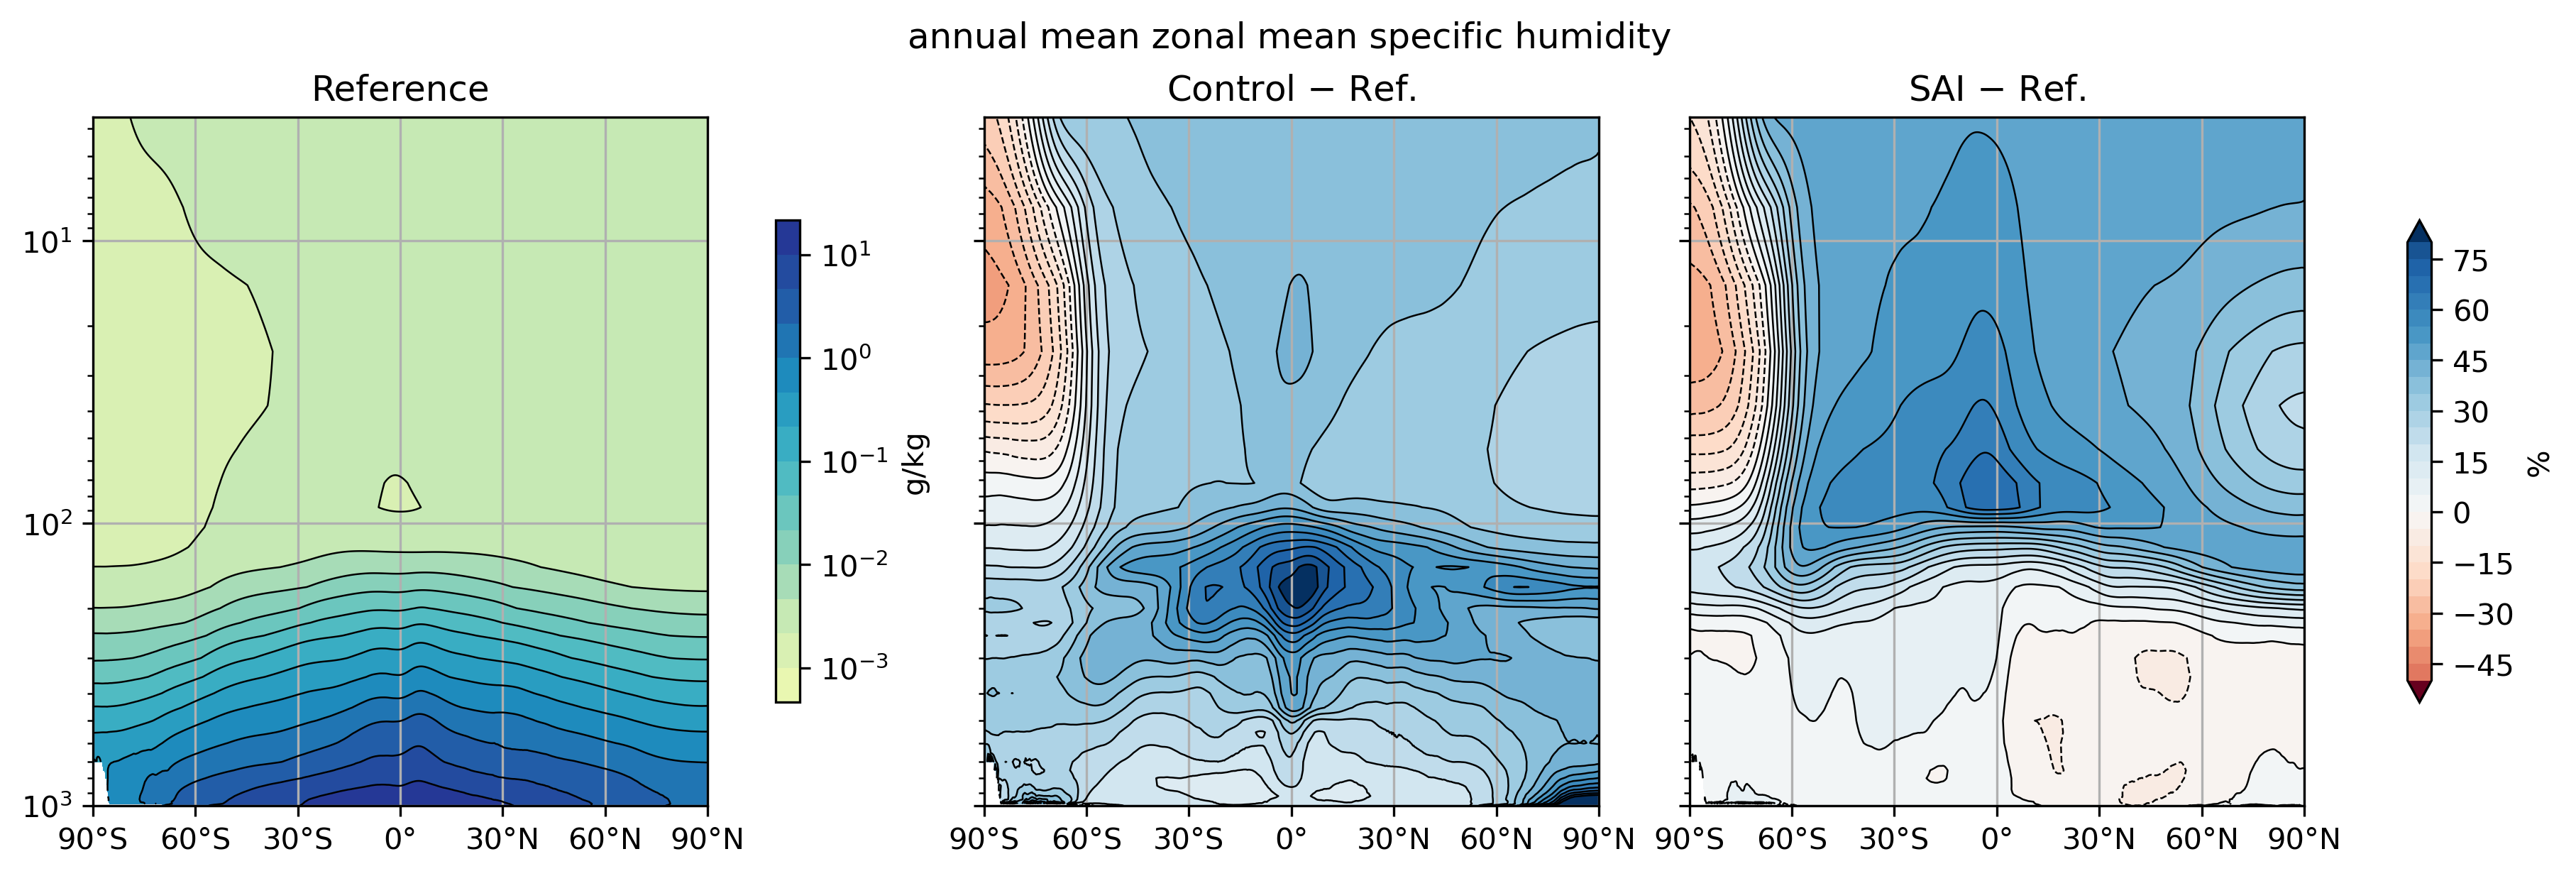

In [5]:
data = ds[NAME].weighted(ds.dpm).mean('month')

kwargs = dict()

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', sharex=True, sharey=True)

ax=axs[0]
pcm = ax.contourf(data.lat, data.plev/100, data.sel(exp='ref'), **cfkwargs_abs)
psm = ax.contour(data.lat, data.plev/100, data.sel(exp='ref'), levels=pcm.levels, colors='k', linewidths=0.6, **kwargs)
#pcm.set_rasterized(True)
#psm.set_rasterized(True)
#ax.contour(data.lon2d, data.lat2d, data.sel(exp='ref'), levels=[25], colors='k', linewidths=1.2, linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ticks=10**np.arange(-3.0,2.0), ax=axs[0], shrink=0.7, orientation='vertical')
cb.ax.set_ylabel(cbarunit_abs)
ax.set_title('Reference')

for ax,exp,tit in zip(axs[1:],['cnt-ref','sai-ref'],['Control $-$ Ref.','SAI $-$ Ref.']):
    pcm = ax.contourf(data.lat, data.plev/100, data.sel(exp=exp), **cfkwargs_rel)
    psm = ax.contour(data.lat, data.plev/100, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=[0.6], **kwargs)
    #pcm.set_rasterized(True)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.7, orientation='vertical')
cb.ax.set_ylabel(cbarunit_rel)

for ax in axs:
    ax.invert_yaxis()
    ax.set_yscale('log')
    ax.set_xticks(range(-90,91,30), labels=['90°S','60°S','30°S','0°','30°N','60°N','90°N'])
    ax.grid()

fig.suptitle('annual mean '+LONGNAME)
fig.savefig(f'../figures/{NAME}.annualmean.pdf', bbox_inches='tight', transparent=True)

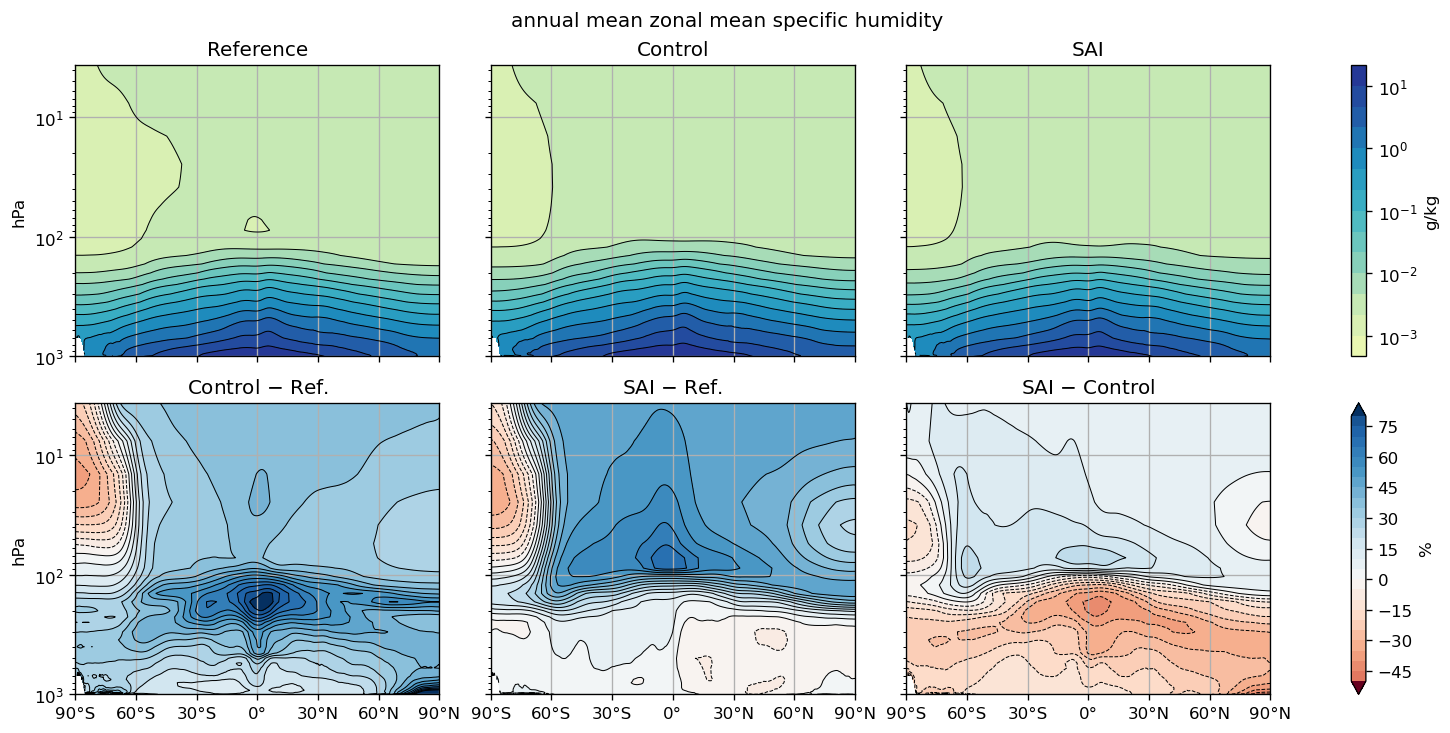

In [6]:
data = ds[NAME].weighted(ds.dpm).mean('month')

kwargs = dict()

fig,axs = plt.subplots(2,3, dpi=120, figsize=(12,6), layout='constrained', sharex=True, sharey=True)

# top row: ref, cnt, sai
for ax,exp,tit in zip(axs[0,:], ['ref','cnt','sai'],['Reference','Control','SAI']):
    pcm = ax.contourf(data.lat, data.plev/100, data.sel(exp=exp), **cfkwargs_abs)
    psm = ax.contour(data.lat, data.plev/100, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=0.6, **kwargs)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pcm.set_rasterized(True)
        psm.set_rasterized(True)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ticks=10**np.arange(-3.0,2.0), ax=axs[0,:], orientation='vertical')
cb.ax.set_ylabel(cbarunit_abs)

# bottom row: differences
for ax,exp,tit in zip(axs[1,:],['cnt-ref','sai-ref','sai-cnt'],['Control $-$ Ref.','SAI $-$ Ref.','SAI $-$ Control']):
    pcm = ax.contourf(data.lat, data.plev/100, data.sel(exp=exp), **cfkwargs_rel)
    psm = ax.contour(data.lat, data.plev/100, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=[0.6], **kwargs)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pcm.set_rasterized(True)
        psm.set_rasterized(True)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[1,:], orientation='vertical')
cb.ax.set_ylabel(cbarunit_rel)

ax = axs.flat[0]
ax.set_yscale('log')
ax.set_xticks(range(-90,91,30), labels=['90°S','60°S','30°S','0°','30°N','60°N','90°N'])
ax.invert_yaxis()

for ax in axs.flat:
    ax.grid()

for ax in axs[:,0]:
    ax.set_ylabel('hPa')

fig.suptitle('annual mean '+LONGNAME)
fig.savefig(f'../figures/{NAME}.annualmean.full.pdf', bbox_inches='tight', transparent=True)

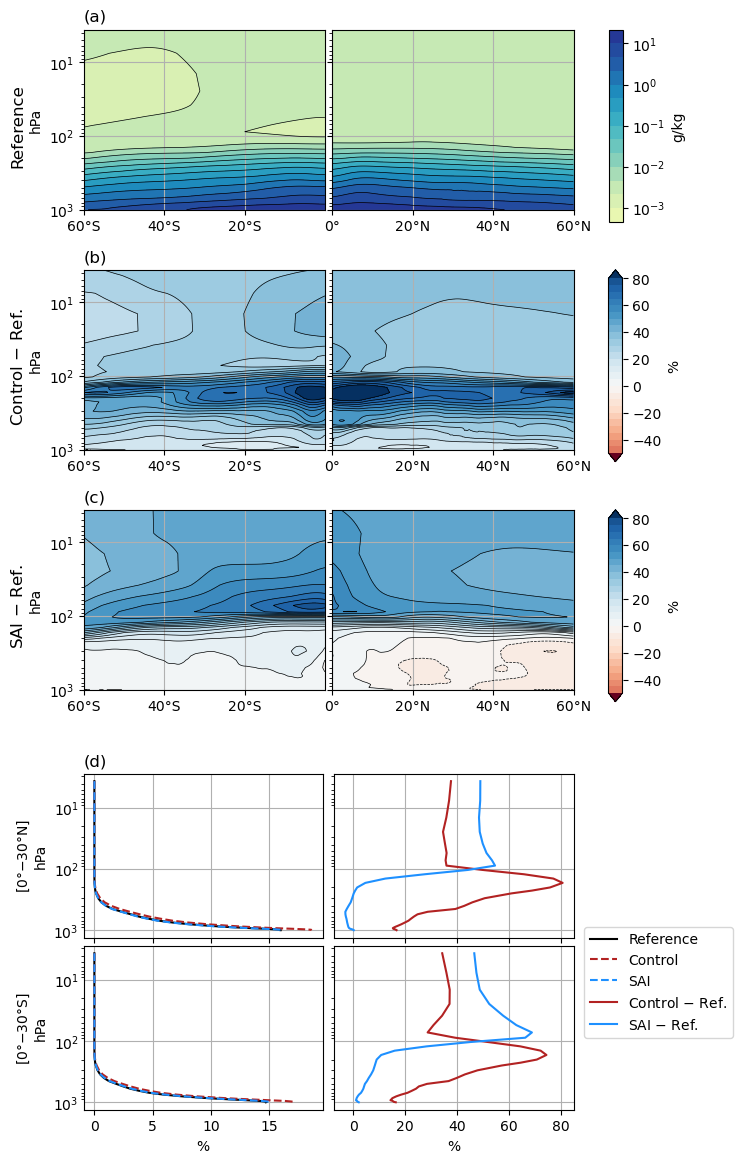

In [7]:
data_NH = ds[NAME].sel(month=MONTHS_NH, lat=slice(0,60)).weighted(ds.dpm).mean('month')
data_SH = ds[NAME].sel(month=MONTHS_SH, lat=slice(-60,0)).weighted(ds.dpm).mean('month')

cfdata = {
    'a': [data_NH.sel(exp='ref'), data_SH.sel(exp='ref')],
    'b': [data_NH.sel(exp='cnt-ref'), data_SH.sel(exp='cnt-ref')],
    'c': [data_NH.sel(exp='sai-ref'), data_SH.sel(exp='sai-ref')],
}

cfkwargs = {'a': cfkwargs_abs, 'b': cfkwargs_rel, 'c': cfkwargs_rel}
cbkwargs = {'a': dict(label=cbarunit_abs), 'b': dict(label=cbarunit_rel), 'c': dict(label=cbarunit_rel)}
supy = {'a': 'Reference', 'b': 'Control $-$ Ref.', 'c': 'SAI $-$ Ref.'}

fig = plt.figure(figsize=(7, 12))
subfigs = fig.subfigures(2, 1, hspace=0.0, height_ratios=[3, 2])
mapfigs = subfigs[0].subfigures(3,1,hspace=0, wspace=0)
zmfig = subfigs[1]#.subfigures(1,1,wspace=0)

for i,mfig, in zip('abc', mapfigs.flatten()):
    axl, axr = mfig.subplots(1,2, sharey=True)
    cft = axr.contourf(cfdata[i][0].lat, cfdata[i][0].plev/100, cfdata[i][0], **cfkwargs[i])
    cfb = axl.contourf(cfdata[i][1].lat, cfdata[i][1].plev/100, cfdata[i][1], **cfkwargs[i])
    cst = axr.contour(cfdata[i][0].lat, cfdata[i][0].plev/100, cfdata[i][0], levels=cft.levels, colors='k', linewidths=0.5)
    csb = axl.contour(cfdata[i][1].lat, cfdata[i][1].plev/100, cfdata[i][1], levels=cfb.levels, colors='k', linewidths=0.5)
    for ax in (axl, axr):
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid()
    axl.set_xticks([-60,-40,-20], labels=['60°S','40°S','20°S'])
    axr.set_xticks([0,20,40,60], labels=['0°','20°N','40°N','60°N'])
    axl.invert_yaxis()
    axl.set_yscale('log')
    mfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.15, hspace=0.05, wspace=0.03)
    cbtax = mfig.add_axes((0.875,0.1,0.02,0.8))
    #mfig.colorbar(cft, ticks=cft.levels, cax=cbtax, **cbkwargs[i])
    mfig.colorbar(cft, ticks=(10**np.arange(-3.0,2.0) if i=='a' else cft.levels[2::4]), cax=cbtax, **cbkwargs[i])
    axl.set_title(f'({i})', loc='left')
    axl.set_ylabel('hPa')
    mfig.supylabel(supy[i])

axs = zmfig.subplots(2,2, sharey=True, sharex='col')
zmfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.2, wspace=0.05, hspace=0.05)
for ax in axs[:,1]:
    ax.yaxis.set_tick_params(length=0)
for ax in axs[:,0]:
    ax.yaxis.set_tick_params(length=0)

coldata_NH = data_NH.sel(lat=slice(0,30)).weighted(ds.gw).mean('lat')
zmfig.axes[0].plot(coldata_NH.sel(exp='ref'), coldata_NH.plev/100, c='k', label='Reference')
zmfig.axes[0].plot(coldata_NH.sel(exp='cnt'), coldata_NH.plev/100, c='firebrick', ls='--', label='Control')
zmfig.axes[0].plot(coldata_NH.sel(exp='sai'), coldata_NH.plev/100, c='dodgerblue', ls='--', label='SAI')

zmfig.axes[1].plot(coldata_NH.sel(exp='cnt-ref'), coldata_NH.plev/100, c='firebrick', label='Control $-$ Ref.')
zmfig.axes[1].plot(coldata_NH.sel(exp='sai-ref'), coldata_NH.plev/100, c='dodgerblue', label='SAI $-$ Ref.')

coldata_SH = data_SH.sel(lat=slice(-30,0)).weighted(ds.gw).mean('lat')
zmfig.axes[2].plot(coldata_SH.sel(exp='ref'), coldata_SH.plev/100, c='k', label='Reference')
zmfig.axes[2].plot(coldata_SH.sel(exp='cnt'), coldata_SH.plev/100, c='firebrick', ls='--', label='Control')
zmfig.axes[2].plot(coldata_SH.sel(exp='sai'), coldata_SH.plev/100, c='dodgerblue', ls='--', label='SAI')

zmfig.axes[3].plot(coldata_SH.sel(exp='cnt-ref'), coldata_SH.plev/100, c='firebrick', label='Control $-$ Ref.')
zmfig.axes[3].plot(coldata_SH.sel(exp='sai-ref'), coldata_SH.plev/100, c='dodgerblue', label='SAI $-$ Ref.')

han1, lab1 = zmfig.axes[0].get_legend_handles_labels()
han2, lab2 = zmfig.axes[1].get_legend_handles_labels()
zmfig.legend(han1+han2, lab1+lab2, loc=(0.84,0.35))

axs[0,0].invert_yaxis()
axs[0,0].set_yscale('log')


zmfig.axes[0].set_title('(d)', loc='left')
zmfig.axes[0].set_xlabel('')
zmfig.axes[0].set_ylabel(r'[0°$-$30°N]'+'\nhPa')
zmfig.axes[1].set_xlabel('')
zmfig.axes[2].set_xlabel(cbarunit_rel)
zmfig.axes[2].set_ylabel(r'[0°$-$30°S]'+'\nhPa')
zmfig.axes[3].set_xlabel(cbarunit_rel)

for ax in zmfig.axes:
    ax.yaxis.set_tick_params(length=0)
    # ax.set_title('')
    # ax.set_ylabel('')
    ax.grid()

fig.savefig(f'../figures/{NAME}.TCseason.pdf', transparent=True, bbox_inches='tight')

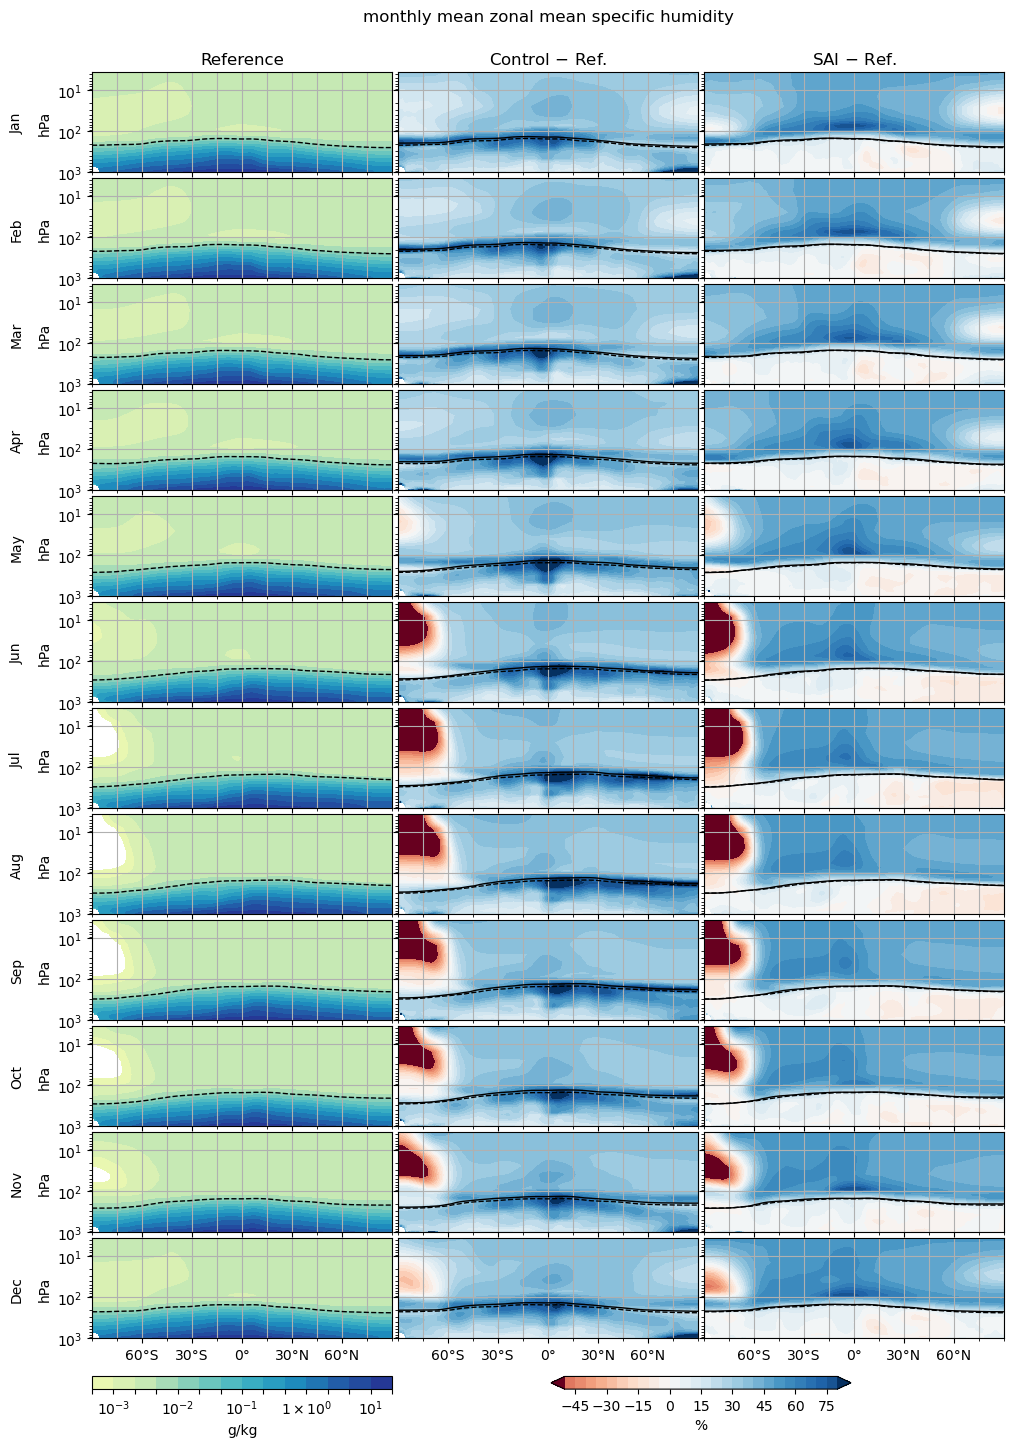

In [9]:
data = ds[NAME]

fig, axs = plt.subplots(12, 3, figsize=(9.12,12.66), sharex=True, sharey=True)

for m,mon in enumerate(data.month):
    for i,exp in enumerate(['ref','cnt-ref','sai-ref']):
        datai = data.sel(exp=exp, month=mon)
        if i > 0:
            cf = axs[m,i].contourf(datai.lat, datai.plev/100, datai, **cfkwargs_rel)
            cs = axs[m,i].contour(datai.lat, datai.plev/100, data.sel(exp=exp.split('-')[0], month=mon), levels=[1e-2], colors='k', linewidths=1, linestyles='-')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cf.set_rasterized(True)
                cs.set_rasterized(True)
        else:
            cfr = axs[m,i].contourf(datai.lat, datai.plev/100, datai, **cfkwargs_abs)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cfr.set_rasterized(True)
        cs = axs[m,i].contour(datai.lat, datai.plev/100, data.sel(exp='ref', month=mon), levels=[1e-2], colors='k', linewidths=1, linestyles='--')      
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cs.set_rasterized(True)
        axs[m,i].grid(which='both', axis='x')
        axs[m,i].grid(which='major', axis='y')

for e,exp in enumerate(['ref','cnt-ref','sai-ref']):
    axs[0,e].set_title(['Reference','Control $-$ Ref.','SAI $-$ Ref.'][e])

fig.subplots_adjust(bottom=0, top=1, left=0, right=1,
                    wspace=0.02, hspace=0.06)
cbr_ax = fig.add_axes([0, -0.04, 3/9.12, 0.01])
cb_ax = fig.add_axes([4.59/9.12, -0.04, 3/9.12, 0.01])
cbr = fig.colorbar(cfr, cax=cbr_ax, ticks=cfr.levels, orientation='horizontal', label=cbarunit_abs)
cb = fig.colorbar(cf, cax=cb_ax, ticks=None, orientation='horizontal', label=cbarunit_rel)

axs[0,0].invert_yaxis()
axs[0,0].set_yscale('log')

for m,ax in enumerate(axs[:,0]):
    bbox = ax.get_position()
    fig.text(bbox.x0-0.25*(bbox.x1-bbox.x0),(bbox.y0+bbox.y1)/2,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][m], ha='center', va='center', rotation=90)
    ax.set_ylabel('hPa')

axs[-1,0].set_xticks(range(-60,61,30), labels=['60°S','30°S','0°','30°N','60°N'])
ax.set_xticks(range(-90,91,15), minor=True)
fig.suptitle('monthly mean '+LONGNAME, y=1.05)
fig.savefig(f'../figures/{NAME}.monmean.pdf', dpi=120, transparent=True, bbox_inches='tight')